# Technical Design Document

This document outlines the technical design for the project, including architecture, data flow, components, diagrams and decisions for the implementation of the machine learning project.
>This project seeks to predict machine failures using historical sensor data and machine learning techniques. The goal is to build a predictive
maintenance system that can forecast potential failures before they occur, allowing for proactive maintenance actions.

## Table of Contents
1. [Data Loading](#1-data-loading)
2. [Preliminary Exploratory Data Analysis](#2-preeliminary-exploratory-data-analysis)
3. [Data Preprocessing](#3-data-preprocessing)
4. [Feature Engineering](#4-feature-engineering)
5. [Model Training](#5-model-training)
6. [Model Evaluation](#6-model-evaluation)
7. [Evaluation Summary and Reporting](#7-evaluation-summary-and-reporting)
8. [Deployment and Containerization](#8-deployment-and-containerization)

## 1. Data Loading

The first step in the project is to load the data from the source. The data is stored in a CSV format and contains sensor readings from various machines along with their operational status. There are five main CSV files that need to be loaded, all available in the Kaggle's Microsoft Azure Predictive Maintenance datasets [here](https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance/data).

This data can also be found in the `data` directory of the project repository, after running the `src/data_acquistion.py` script, which will download the data from Kaggle, order, parse, and save it in the appropriate format.
The data loading process involves reading the CSV files into Pandas DataFrames, which allows easy manipulation and analysis of the data. The following code snippet demonstrates how to download the data:

```python
    import kagglehub
    import pandas as pd

    path = kagglehub.dataset_download("arnabbiswas1/microsoft-azure-predictive-maintenance")
    print("\nPath to dataset files:", path)

```
The dataset contains the following files, named as saved in the `data` directory:
>- `telemetry.csv`: Which consists of hourly average of voltage, rotation, pressure, vibration collected from 100 machines for the year 2015.

>- `error.csv`: Which consists of the error encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

>- `maintenance.csv`: This file contains records of component replacements for the machines. Rounding the data the closest hour, since the telemetry data is collected at an hourly rate. Components are replaced under two situations:
  >>- Proactive Maintenance: When during the regular scheduled visit, the technician replaced it .
  >>- Reactive Maintenance: When a component breaks down and then the technician does an unscheduled maintenance to replace the component

>- `failure.csv`: This file contains records that  represent replacement of a component due to failure.This data is a subset of Maintenance data. The failure date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

>- `machines.csv`: This file contains metadata about the machines, such as their model and age.

#### Note
The date times in the original dataset are written in the ISO 8601 date format and are objects. Python recognizes this format so this columns can be easily made into dates using the `parse_date` function. 


## 2. Preeliminary Exploratory Data Analysis
The next step is to perform preliminary exploratory data analysis (EDA) on the loaded data. This involves examining the data to understand its structure, identify any missing values, and gain insights into the relationships between different variables. This step is crucial for understanding the data and preparing it for further analysis. This analysis is performed in the `src/eda.py` script.
This step includes:
- Checking the data types of each column to ensure they are appropriate for analysis.
- Displaying basic information about the datasets (shape and first 5 rows).
- Identifying and handling missing/duplicated values.*
- Displaying summary statistics for numerical columns to understand their distributions.
- Visualizing the distribution of key variables to understand their characteristics.
- Identifying any outliers or anomalies in the data that may need to be addressed.
- Checking the relationships between different variables to identify potential correlations or patterns.


From the preliminary EDA, we can summarize the following insights:
>- All the date columns have been accurately converted to datetime64[ns] data type.
>- All the datasets share a common column `machine_id` made of integers, which can be used to join the datasets.
>- There are no missing values in the datasets.
>- There are no duplicated rows in the datasets.
>- With the exception of the maintenance dataset that begins in June 1, 2014, all the datasets contain data from January 1, 2015 to January 1, 2016.
>- Since there are only 6 hours of data from January 1, 2016, these rows can be dropped from the datasets to avoid any bias in the analysis.
>- The telemetry dataset contains continuous numerical variables (voltage, rotation, pressure, vibration) with a distribution similar to a Gaussian/Normal, that can be used as features for modeling.

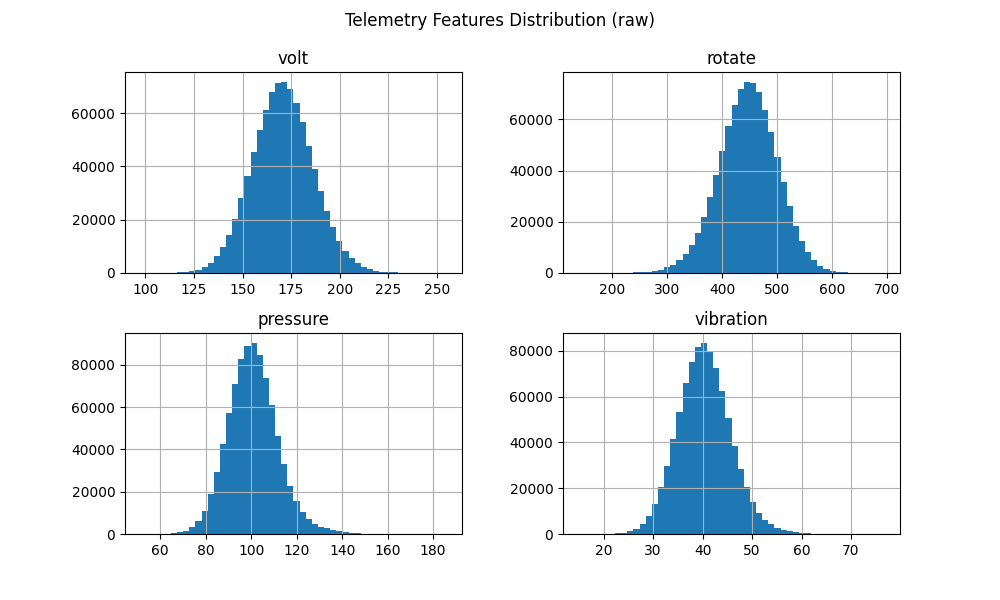

>- The error and failure datasets contain categorical variables (error types and failure types) that can be used as features for modeling.
>- There are no outliers in the datasets, as all the values are within a reasonable range.
>- There are no correlations between the variables, as all the correlation coefficients are close to zero. Meaning that the variables are independent of each other, preventing multicollinearity issues in the modeling phase.

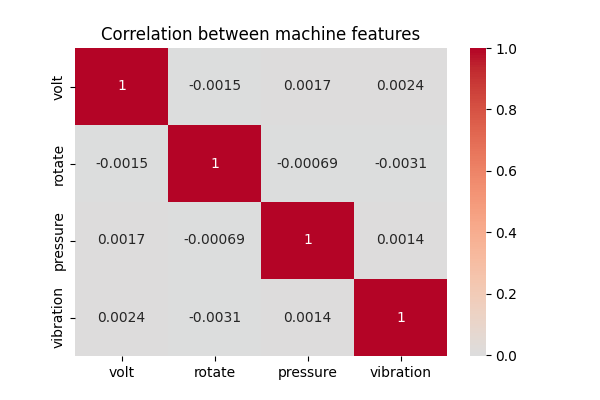

## 3. Data Preprocessing
The next step is to preprocess the data to prepare it for modeling. This involves cleaning the data, generating the target variables, handling missing values, merging and transforming the data into a suitable format for analysis. The preprocessing steps are performed in the `src/data_preprocessing.py` script.
This step includes:
- Cleaning the data by removing any unnecessary columns or rows that are not relevant to the analysis, this includes the data from year 2016. As no missing values, duplicated rows or outliers were found in the EDA, no further cleaning is required.
- Generating the target variables, which are the labels for the machine learning models. The target variables are generated based on the failure and maintenance datasets, which contain records of component replacements due to failure or proactive/reactive maintenance. The target variables are:
  >- `will_fail_in_24h`: A binary variable indicating whether a machine will fail within the next 24 hours.
  >- `will_fail_in_48h`: A binary variable indicating whether a machine will fail within the next 48 hours.
Both target variables will be used for training classification models, to determine which create the most accurate predictions.
- A sanity check is performed to ensure that the target variables are correctly generated, and that there was no temporal leakage from the future data into the past data.


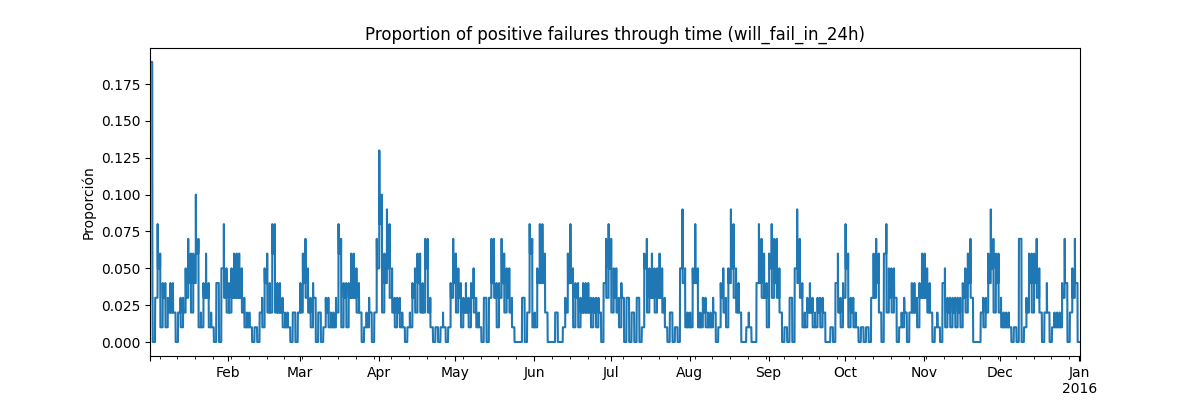
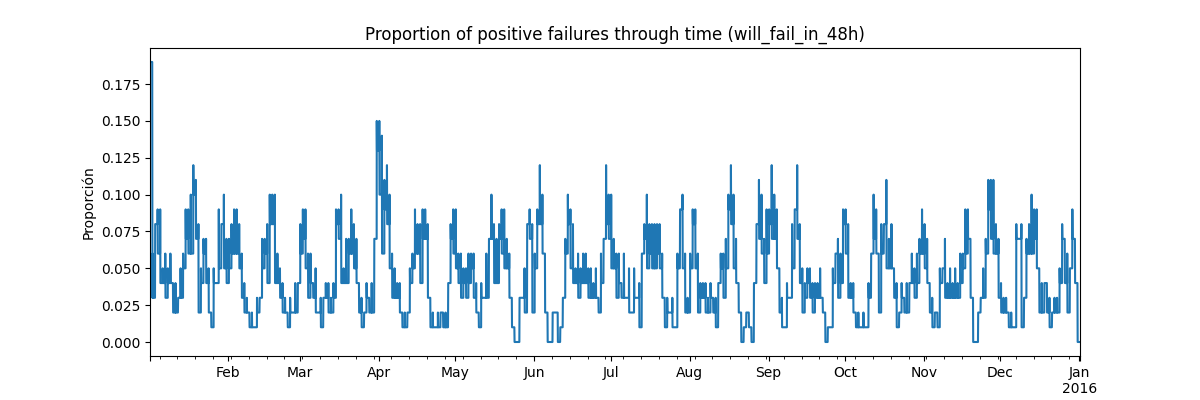


- Merging the datasets into a single DataFrame, which contains all the relevant information for each machine. The merging is done based on the `machine_id` column, which is common to all datasets.
- The processed data is then saved as a CSV file in the `data/processed` directory for further analysis.



## 4. Feature Engineering
The feature engineering step involves creating new features from the existing data that can help improve the performance of the machine learning models. This step is performed in the `src/data_processing.py` script and it includes:
- Creating new features based on the existing sensor data, such as lags, rolling averages, rolling standar deviations and slopes features. These features can help capture trends and patterns in the sensor data that may be indicative of impending failures.
- Encoding categorical variables, such as error types and failure types, into numerical values that can be used in the machine learning models.
- Normalizing or scaling the numerical features to ensure that they are on a similar scale, which can help improve the performance of the models.
New features were added into the main DataFrame, which contains all the relevant information for each machine, and saved as a CSV file in the `data/processed` directory for further analysis.

## 5. Model Training
The model training step involves selecting appropriate machine learning algorithms and training them on the preprocessed data. This step is crucial for building a predictive model that can accurately forecast machine failures. This step is performed in the `src/model.py` script.

Two types of classification models will be trained:
- **Logistic Regression (LR)**: A simple linear model that is easy to interpret and can be used as a baseline for comparison with more complex models.
- **Random Forest (RF)**: An ensemble model that can capture complex relationships in the data and is often more accurate than simpler models.

The models will be trained on the preprocessed data, using the target variables generated in the previous step. The training process involves splitting the data into training, validation, and test sets, fitting the models to the training data, and evaluating their performance on the validation set. The best-performing of the four resulting models, two LR's and two RF's,  will be selected for further evaluation and deployment. All the models will be saved in the `data/models` directory in the .joblib format, which allows for easy loading and inference in the future.





## 6. Model Evaluation
The model evaluation step involves assessing the performance of the trained models using various metrics. This step is essential to ensure that the models are capable of making accurate predictions on unseen data. And it is performed in the `src/model.py` script.

The evaluation metrics include accuracy, precision, recall, specificity, F1-score, Fbeta score, receiver operating characteristic (ROC) curve, area under the ROC curve (AUC), average precision curve, and area under the average precision curve. 

This metrics will be used to compare the performance of the different models and select the best one for deployment. Their visualizations will be saved in the `data/figures` directory for further analysis and reporting found in the `technical_report.ipynb` notebook.

## 7. Evaluation Summary and Reporting
This step involves summarizing the results of the model evaluation and generating a report that includes the key findings, insights, and recommendations. This step is performed in the `technical_report.ipynb` notebook. Key metrics will be saved as a CSV in the main repository for easy access and sharing.

## 8. Deployment and Containerization
The final step is to deploy the trained model as a REST API using FastAPI. This allows users to make predictions by sending requests to the API with input data. The deployment process involves creating an API endpoint that accepts input data, processes it, and returns predictions based on the trained model. This step is performed in the `src/app.py` script.

For deployment, the FastAPI application is containerized using Docker. The Dockerfile is provided in the `src` directory, which contains the necessary instructions to build the Docker image for the FastAPI application, which can be done with the following command:

```bash
# Build the Docker image for the FastAPI application
docker build -t predictive-maintenance

# Run the Docker container for the FastAPI application
docker run -p 8000:8000 predictive-maintenance

```
For testing the deployment the following code snippet was used to run the FastAPI application locally:

```bash
# Run the FastAPI application locally
uvicorn src.app:app --port 8000
```
This API expects a POST request with a file containing the input data in CSV format. The input data should have a similar structure to the raw data containing a `datetime`, `machine_id`, `model`, `age` columns and the sensor readings columns (voltage, rotation, pressure, vibration) for the machines, named as such. This can be done by merging the `telemetry.csv` and `machines.csv` raw files from the data set. The request should be made to the `/predict/{model_name}` endpoint, where `{model_name}` is the name of the model to be used for predictions `LR_48h` `RF_48h` `LR_24h` `RF_48h` (e.g., `RF_48h` for the Random Forest model predicting failures in 48 hours).

A test input was created, and the following code snippet can be used to test the deployment:

```bash
# Example API request to test the deployment
curl -X POST "http://localhost:8000/predict/RF_48h" -H "Content-Type: multipart/form-data" -F "file=@input_data.csv"

# Expected Output Structure
{"predictions":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]}
```
